# Dask for Xarray

This notebook is a light introduction to [Dask](https://www.dask.org) for [Xarray](https://xarray.dev), more as a bag of tips than a lecture on both tooloboxes.

It is recommended to have a good read of the official documentations to complete this document:

- the [Xarray documentation part about Dask](https://docs.xarray.dev/en/stable/user-guide/dask.html),
- the [Dask](https://docs.dask.org) and the [Dask.distributed](https://distributed.dask.org) documentations.https://distributed.dask.org


## Introduction to Dask

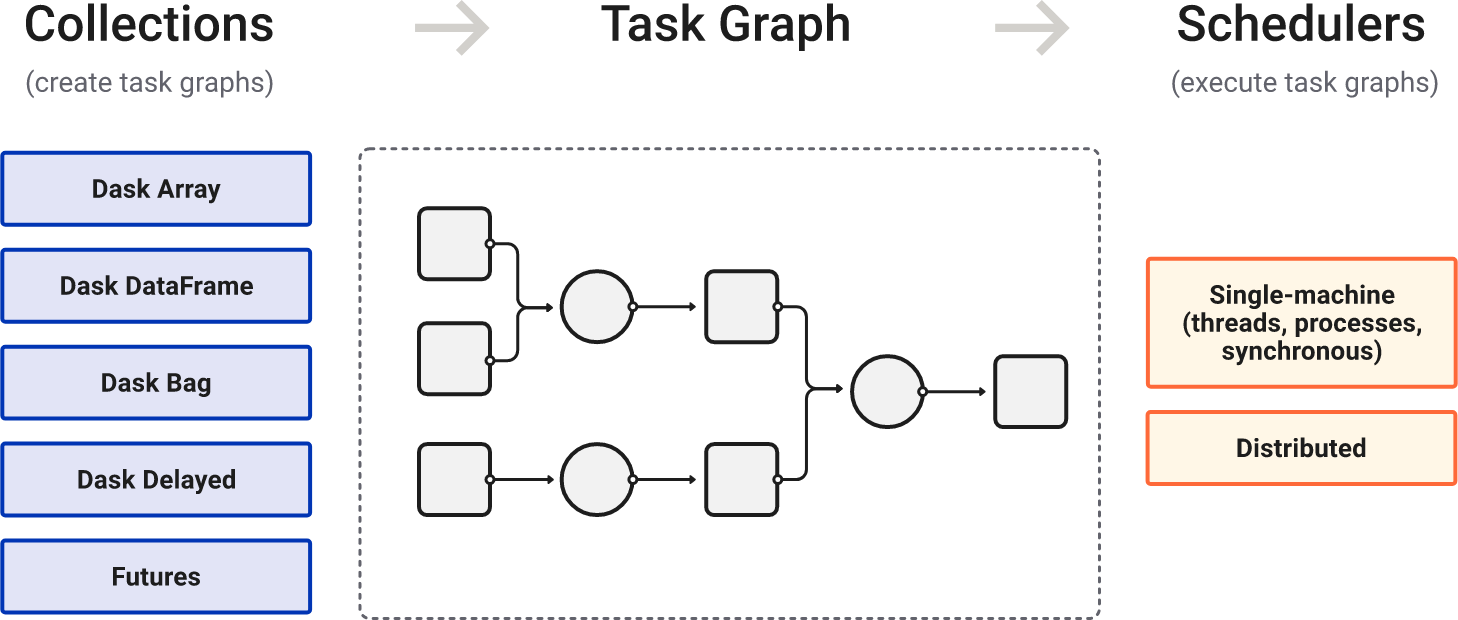

*Figure from [Dask documentation](https://docs.dask.org)*

Dask is made of multiple parts that makes it very versatile:

- a set of high level familiar APIs (i.e. numpy-like, pandas-like, etc.), making it easy to express a complex problems
- that are decomposed into tasks linked into a tasks graph
- which get execute by a scheduler, which assign task to a set of workers that can be deployed in different environments (local machine, HPC, cloud, ...).

Dask helps with processing many tasks in parallel, but not every problem needs task:

- the standard library options (`multiprocessing`, `concurrent.futures`) are sometimes just a good for embarrassigly parallel task on one workstation,
- [Joblib](https://joblib.readthedocs.io) is also a very good light wrapper that makes multiprocessing a lot easier,
- for parallelism across nodes in an HPC, [MPI4py](https://mpi4py.readthedocs.io) can also be a good candidate,
- and [Ray](https://ray.io) is another alternative for more advance distributed computing.

Now Dask really shines if you can:

- express your problem with one of the high-level API, e.g. you can use the dataframe API to operate on a very large pandas-like data structure,
- you may have non-trivial dependencies between your tasks,
- have enough tasks (but not too much) to make it worth the extra complexity :D, and each task is not too short.
  - I would recommend to stay below 1 millions tasks, otherwise the scheduler might take too much time doing bookkeeping,
  - and get tasks that are not faster than half a second each (ideally run from 10 seconds to few minutes), otherwise the program will spend its time mostly scheduling tasks.

## Dask Array API

A typical problem that fits this description is too process a very large raster dataset, if it can be process by tiles and/or time slices for example.

An ideal Dask API to do this is the [Dask array](https://docs.dask.org/en/stable/array.html) API, that mimics the numpy API.
Under the hood, the manipulated array is made of *chunks*, each being associated with a task.

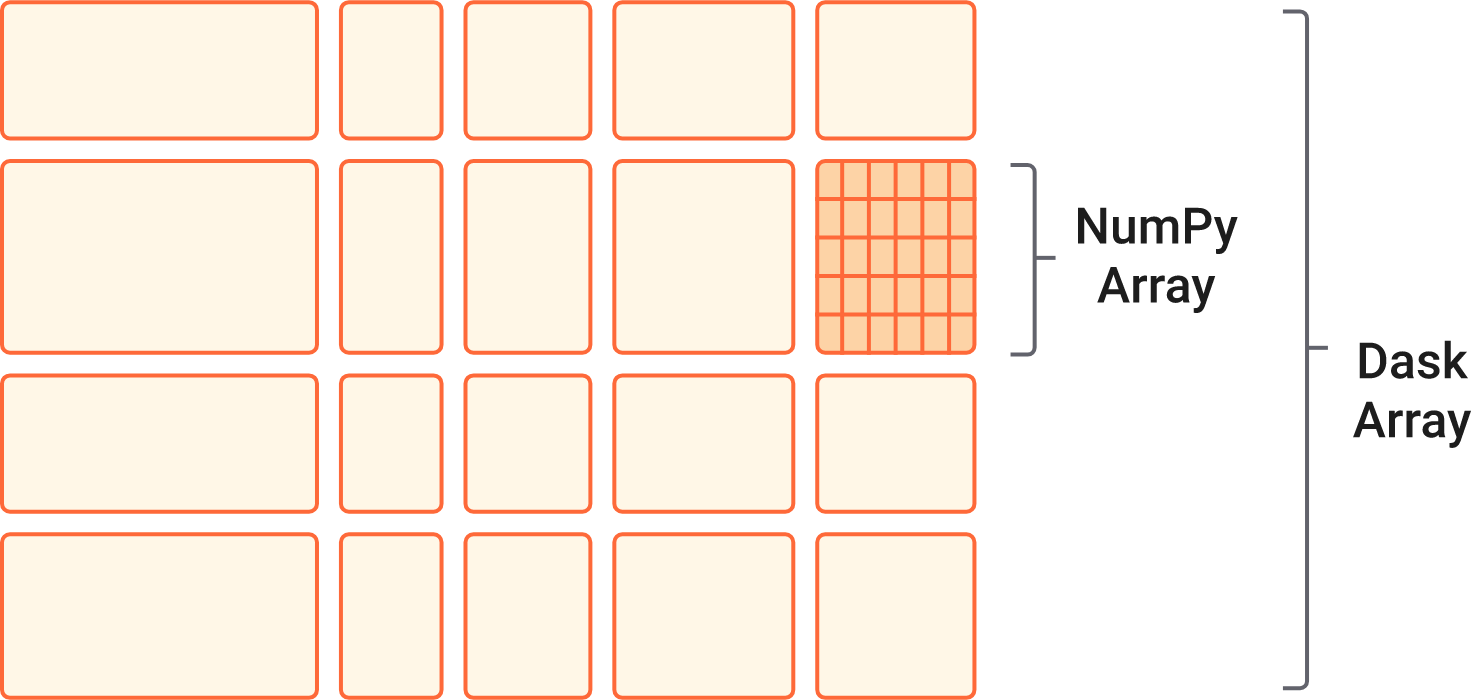

In [ ]:
import dask.array as da

In [ ]:
my_array = da.ones(100, chunks=20)
my_array

Every time an operation is applied on one or more Dask arrays, nothing is executed.

A new Dask array is produced, that contains the information (the Dask graph ;-)) of what would need to be computed to obtain the results for each *chunk*.

In [ ]:
my_new_array = my_array + 30
my_new_array

In [ ]:
my_new_array.visualize()

There are multiple ways to trigger the computation (more on this in the Xarray section) on of them is to call the `.compute()` method of the Dask array object.
It returns a numpy array.

In [ ]:
my_new_array.compute()

## Fetching some data to analyse

We'll get monthly sea surface temperature as a dataset and perform a simple analysis on it.

In [ ]:
!wget -q https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc -O sst.mnmean.nc

In [ ]:
import xarray as xr

In [ ]:
dset = xr.open_dataset("sst.mnmean.nc", drop_variables=["time_bnds"])

In [ ]:
dset

The sea surface temperature dataset goes from the 19s century until today.

In [ ]:
dset.isel(time=[0, -1]).sst.plot(x="lon", y="lat", col="time")

For this analysis, we select only the last 4 decades.

In [ ]:
sst_recent = dset.sel(time=slice("1980-01-01", "2020-12-31"))["sst"]
sst_recent

Note that under the hood, it is just a numpy array, with additional metadata (dimensions, coordinates, attributes) to make easier to manipulate.

In [ ]:
sst_recent.values

Next, let's compute a monthly average across all years and treat it as our climatology.

In [ ]:
climatology = sst_recent.groupby(sst_recent.time.dt.month).mean()
climatology

We subtract the climatology to get a sea surface temperature anomaly dataset.

In [ ]:
sst_anomalies = sst_recent.groupby(sst_recent.time.dt.month) - climatology
sst_anomalies

And to finish this toy analysis, we compute for each year the maximum anomaly at each lat/lon location.

In [ ]:
sst_max_anom = sst_anomalies.groupby(sst_anomalies.time.dt.year).max()
sst_max_anom

In [ ]:
sst_max_anom.isel(year=[0, 10, 20, 30, 40]).plot(x="lon", y="lat", col="year", col_wrap=3)

## Xarray with Dask

One interesting feature of Xarray is that it can use either numpy arrays or Dask arrays to manipulate the underlying data.

We will now repeat the same analysis, but using Dask arrays.

First, we need to convert the Xarray Dataset/DataArray to use Dask arrays:

- this can be done at loading time, by using the `chunks` parameter (in which case no data is loaded),
- or it can be done after loading the data, by using the `chunk()` method of the Dataset/DataArray object.

It is important to pick the chunk size wisely:

- it determines how much memory each task will need (and likely the speed), so make it bigger than smaller to avoid too many micro-tasks,
- if loading from disk, it will impact how data is read from disk, contiguous data being in general faster to fetch (and some formats store data in chunks, it's best to match those).

In [ ]:
dset = xr.open_dataset(
    "sst.mnmean.nc", chunks={"time": 120}, drop_variables=["time_bnds"]
)

Note that now the type of the `sst` variable is `dask.array<chunksize=...>`.

In [ ]:
dset

If you use **.values** to access the raw data in a DataArray, this will trigger the computations, loading all the data into memory.

It is preferable, if you really need to access it, to use the **.data** member, that will not coerce the Dask array into a numpy array.

In [ ]:
dset.sst.data

Then we can reproduce all the previous operations, using the Xarray API, and see that we keep a Dask array as data container.

In [ ]:
sst_recent = dset.sel(time=slice("1980-01-01", "2020-12-31"))["sst"]
sst_recent

In [ ]:
climatology = sst_recent.groupby(sst_recent.time.dt.month).mean()
climatology

In [ ]:
sst_anomalies = sst_recent.groupby(sst_recent.time.dt.month) - climatology
sst_anomalies

In [ ]:
sst_max_anom = sst_anomalies.groupby(sst_anomalies.time.dt.year).max()
sst_max_anom

All these operations are *lazy*, meaning that no computations have been executed, only the task graph to obtain the results has been recorded.

We can pick under the curtain and have a look at a subset of this graph ;-).

In [ ]:
sst_max_anom.isel(year=[0, 1]).data.visualize(optimize_graph=True)

Finally, it is time to run this task graph, i.e. get some results.
There are multiple options, typical ones are:

- use the `.compute()` method to create a new Dataset/DataArray with result data stored in a numpy array,
- use the `.load()` method to replace the Dask array with a numpy array within the same Dataset/DataArray object,
- save to disk, e.g. using `.to_netcdf()`, which will run the computation and save to disk.

If your data is very large and you don't need to visualise it, the last option is the best, as it ensures that the whole dataset might never be loaded into memory, only few chunks of it at a time.

In [ ]:
sst_max_anom_with_data = sst_max_anom.compute()
sst_max_anom_with_data

In [ ]:
sst_max_anom_with_data.isel(year=[0, 10, 20, 30, 40]).plot(x="lon", y="lat", col="year", col_wrap=3)

Note you can also plot a subset directly from the Dask backed Xarray DataArray object.

In [ ]:
sst_max_anom.isel(year=[0, 10, 20, 30, 40]).plot(x="lon", y="lat", col="year", col_wrap=3)

TODO describe `apply_ufunc` and `map_blocks`

## Distributed scheduler(s)

So far, we have been using the lazy computation aspects of Dask without paying attention to the parallel computation side of things.

It is time to pick a scheduler:

- the default **single-machine** scheduler,
- the **distributed** scheduler.

The single-machine scheduler can be used with different backends:

- multithreaded, the default, only recommended if your code spends most of its time in compiled functions (C/C++, Fortran) that release the GIL (Global Interpreter Lock),
- multiprocesses, which creates children processes and pass code and data to them,
- single-threaded, which disable all parallelism, which is very convenient for debugging!

The distributed scheduler also has multiple backends, making it very very very versatile:

- `LocalCluster`, which behaves by default like the single-machine scheduler with processes... with additional goodies,
- `SlurmCluter` (from the [jobqueue](https://jobqueue.dask.org) package) to use Slurm jobs to host worker processes,
- [Dask-MPI](http://mpi.dask.org) to use MPI ranks to host worker processes,
- [`SSHCluster`](https://docs.dask.org/en/latest/deploying-ssh.html) to spawn workers on other machines where you can ssh,
- and more to run on Kubernetes, cloud providers, etc.

Among the benefits of the distributed scheduler, the top one is the dashboard, that we'll talk about in the next section.

So to get started, I would recommend:

- the single-threaded backend for debugging purpose,
- `LocalCluster` (with processes) for everything else.

To use the single-threaded single-machine scheduler, one way is to pass the argument `scheduler="synchronous"` to the `.compute()` or `.load()` method.

In [ ]:
sst_max_anom.compute(scheduler="synchronous")

The [`LocalCluster`](https://distributed.dask.org/en/stable/api.html#distributed.LocalCluster) scheduler, like all distributed scheduler needs a little bit more ceremony.

First create a `LocalCluster` cluster object, then connect a `Client` to it.
All the Dask code executed after (including the Dask code used via Xarray) will use this default client to connect to the scheduler.

In [ ]:
from dask.distributed import Client, LocalCluster

In [ ]:
cluster = LocalCluster()
cluster

In [ ]:
client = Client(cluster)
client

If you can, open a terminal on the same machine and run a monitoring tool (e.g. `htop -u $USER`) to see the Dask worker and their activity while running tasks.
We'll see a better way to monitor in the next section.

In [ ]:
sst_max_anom.compute()

Once you don't need the cluster, you can turn it off, and close the client attach to it.

In [ ]:
cluster.close()
client.close()

A cleaner and safer way to do this, is to use a context manager.

In [ ]:
cluster = LocalCluster()
with cluster, Client(cluster):
    sst_max_anom.compute()

Finally, some good practices when using `LocalCluster`:

- one a shared machine, make sure to specify the number of workers, to avoid using all cores of the machine,
- make sure to also put a memory limit on the workers, to be on the safe side, i.e. workers will be restarted when using too much memory (instead of crashing the machine or your Slurm job for example).

In [ ]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=1,  # unless your code support multithreading
    processes=True,  # this is the default, but it is good to know ;-)
    memory_limit="1GB"  # memory limit per worker
)

In [ ]:
with cluster, Client(cluster):
    sst_max_anom.compute()

### Client shortcut

You actually don't need to create a `LocalCluster` explicitely.
Passing its parameters to `Client` creates a `LocalCluster` for you:

```
client = Client(n_workers=2, memory_limit="1GB")
```

is the same as 

```
cluster = LocalCluster(n_workers=2, memory_limit="1GB")
client = Client(cluster)
```

I prefer the second way, more explicit, especially in case when I want to be able to instantiate the client with diffrent types of cluster (e.g. a `SlurmCluster` object).

### Multithreading vs. multiprocessing

I tend to prefer multiprocessing as it is more reliable in the what it delivers, for the good and the less good parts:

- the code is always executed in parallel, whether it release the GIL or not, so I don't have to worry about it,
- but data needs to be copied from the main script to the worker processes, which can have an impact on performances and total memory consumption.

On the other hand, multithreading will avoid redundant copies of the data between the main code and the workers, but parallel computing is only achieved if the underlying code is spending most of its time in compiled code that releases the GIL.
I have found this last assumption not easy to verify but in very simple cases (e.g. only using simple numpy functions).

### The ProgressBar

For the single-machine scheduler, Dask provides a convenient progress bar object... that prints a progress bar during the computation.

In [ ]:
from dask.diagnostics import ProgressBar

In [ ]:
with ProgressBar():
    sst_max_anom.compute()

This is not available for the **distributed** scheduler, but fear not, the Dask dashboard replaces it and brings much much more.

## The Dask dashboard

TODO present the amazing dashboard (and how to use the jupyter reverse proxy)

On NeSI,use https://jupyter.nesi.org.nz/user-redirect/proxy/8787/status.

Also works if your Dask code is running in a job, just use the node IP address and the dashboard port number in
`https://jupyter.nesi.org.nz/user-redirect/proxy/NODE_IP:DASHBOARD_PORT/status`.


In [ ]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=1,  # unless your code support multithreading
    processes=True,  # this is the default, but it is good to know ;-)
    memory_limit="1GB"  # memory limit per worker
)
client = Client(cluster)

In [ ]:
client.dashboard_link

In [ ]:
sst_max_anom.compute()

In [ ]:
cluster.close()
client.close()

## Thinking about I/Os

TODO challenges around saving to disk (locking, parallel write, speed of compute vs speed of IOs)

## Worker memory management

TODO discuss about memory limits, pausing and restarts

## Scaling out

TODO maybe a word about scaling up, dask-mpi and SlurmCluster, keep it light